# Imports

In [1]:
!pip install rawpy

In [2]:
import torch
import torchvision
import numpy as np
import rawpy
import imageio
from glob import glob
import matplotlib.pyplot as plt
import zipfile

In [3]:
# download and import the 'align' module
!wget https://raw.githubusercontent.com/martin-marek/hdr-plus-pytorch/main/align.py
import align

--2021-05-06 13:02:57--  https://raw.githubusercontent.com/martin-marek/hdr-plus-pytorch/main/align.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10865 (11K) [text/plain]
Saving to: ‘align.py.2’

align.py.2          100%[===================>]  10.61K  --.-KB/s    in 0s      

2021-05-06 13:02:57 (119 MB/s) - ‘align.py.2’ saved [10865/10865]



In [4]:
device = torch.device('cuda')

# Download images

In [5]:
# download and unzip a burst of raw images
!wget https://storage.googleapis.com/hdr-plus-samples/Monika-RX100-51200-RAW.zip
with zipfile.ZipFile('Monika-RX100-51200-RAW.zip', 'r') as z:
    z.extractall()

--2021-05-06 13:03:03--  https://storage.googleapis.com/hdr-plus-samples/Monika-RX100-51200-RAW.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.211.128, 173.194.213.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.211.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 712905990 (680M) [application/zip]
Saving to: ‘Monika-RX100-51200-RAW.zip.2’

Monika-RX100-51200- 100%[===================>] 679.88M   209MB/s    in 3.3s    

2021-05-06 13:03:07 (209 MB/s) - ‘Monika-RX100-51200-RAW.zip.2’ saved [712905990/712905990]



# Read images

In [6]:
def load_jpeg_images(image_paths):
    """loads rgb pixels from jpeg images"""
    images = []
    for path in image_paths:
        image = torchvision.io.read_image(path)
        image = image.float() / 255
        images.append(image)

    # store the pixels in a tensor
    images = torch.stack(images)
    
    print(f'burst of shape {list(images.shape)} loaded')
    return images

In [7]:
def load_raw_images(image_paths):
    """loads bayer pixels from raw images"""
    images = []
    for path in image_paths:
        with rawpy.imread(path) as raw:
            image = raw.raw_image.copy().astype(np.float32)
            images.append(image)

    # store the pixels in a tensor with an added "channel" dimension
    images = np.stack(images)
    images = torch.from_numpy(images)[:, None, :, :]

    print(f'burst of shape {list(images.shape)} loaded')
    return images

In [8]:
image_dir = 'Monika-RX100-51200-RAW'
image_paths = sorted(glob(f'{image_dir}/*.*'))
images = load_raw_images(image_paths)

burst of shape [35, 1, 3672, 5504] loaded


# Align images

In [9]:
%%time
merged_image = align.align_and_merge(images, device=device)

CPU times: user 7.11 s, sys: 3.55 s, total: 10.7 s
Wall time: 12.9 s


# Plot reference vs. merged image

In [10]:
def get_rgb_values(image_path, bayer_array=None, **kwargs):
    """using a raw file [and modified bayer pixels], get rgb pixels"""
    # open the raw image
    with rawpy.imread(image_path) as raw:
        # overwrite the original bayer array
        if bayer_array is not None:
            raw.raw_image[:] = bayer_array
        # get postprocessed rgb pixels
        rgb = raw.postprocess(**kwargs)
    return rgb

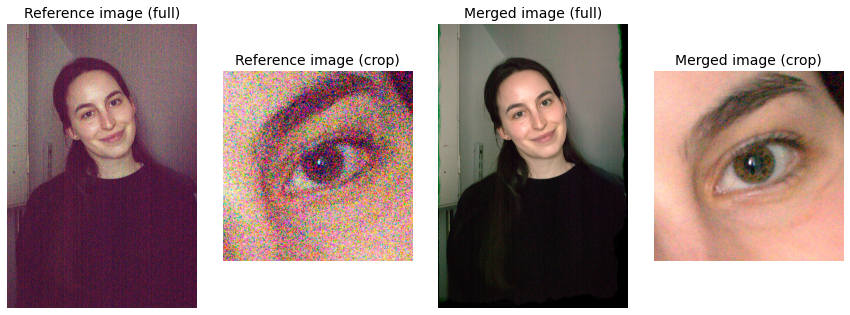

In [11]:
# convert raw images to rgb images
brigthness = 10
ref_rgb = get_rgb_values(image_paths[0], no_auto_bright=True, bright=brigthness)
merged_rgb = get_rgb_values(image_paths[0], merged_image[0], no_auto_bright=True, bright=brigthness)

# figure
font_size = 14
fig, axs = plt.subplots(1, 4, figsize=[12, 8])

# crop
crop_y = [1300, 1800]
crop_x = [1800, 2300]

# reference image
axs[0].imshow(ref_rgb)
axs[0].set_title('Reference image (full)', fontsize=font_size)
axs[1].imshow(ref_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[1].set_title('Reference image (crop)', fontsize=font_size)

# merged burst
axs[2].imshow(merged_rgb)
axs[2].set_title('Merged image (full)', fontsize=font_size)
axs[3].imshow(merged_rgb[crop_y[0]:crop_y[1]:, crop_x[0]:crop_x[1], :])
axs[3].set_title('Merged image (crop)', fontsize=font_size)

for ax in axs:
    ax.set_aspect(1)
    ax.axis('off')
plt.tight_layout()
plt.savefig(f'before_and_after.jpg', bbox_inches='tight')
plt.show()

# Save processed image

In [12]:
with rawpy.imread(image_paths[0]) as raw:
    raw.raw_image[:] = merged_image[0]
    rgb = raw.postprocess(no_auto_bright=True, output_bps=16)
imageio.imsave('merged_burst.tiff', rgb)